In [ ]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM" -O GoogleNews-vectors-negative300.bin.gz && rm -rf /tmp/cookies.txt

--2023-09-21 03:31:28--  https://docs.google.com/uc?export=download&confirm=t&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 142.251.12.100, 142.251.12.139, 142.251.12.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0kg18jlag5o31s3k15rpan01qd6tav3v/1695267075000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=138921b7-e581-4626-951d-0f648c1a423a [following]
--2023-09-21 03:31:29--  https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0kg18jlag5o31s3k15rpan01qd6tav3v/1695267075000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=138921b7-e581-4626-951d-0f648c1a423a
Resolving doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleusercontent.com)... 64.233.170.132, 2404:6800:4003:

### Read data

In [ ]:
# data = pd.read_csv('imdb_labelled.tsv', header = None, delimiter='\t')
#baca data txt seperti diatas
data = pd.read_csv('/content/amazon_cells_labelled.txt', header = None, delimiter='\t')

In [ ]:
data.columns = ['Text', 'Label']

In [ ]:
data.head()

,Text,Label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [ ]:
data.Label.unique()

array([0, 1])

In [ ]:
data.shape

(1000, 2)

In [ ]:
#cek missing value
data.isnull().sum()

Text     0
Label    0
dtype: int64

In [ ]:
pos = []
neg = []
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)

In [ ]:
data['Pos']= pos
data['Neg']= neg

In [ ]:
data.head()

,Text,Label,Pos,Neg
0,So there is no way for me to plug it in here i...,0,0,1
1,"Good case, Excellent value.",1,1,0
2,Great for the jawbone.,1,1,0
3,Tied to charger for conversations lasting more...,0,0,1
4,The mic is great.,1,1,0


In [ ]:
data

,Text,Label,Pos,Neg
0,So there is no way for me to plug it in here i...,0,0,1
1,"Good case, Excellent value.",1,1,0
2,Great for the jawbone.,1,1,0
3,Tied to charger for conversations lasting more...,0,0,1
4,The mic is great.,1,1,0
...,...,...,...,...
995,The screen does get smudged easily because it ...,0,0,1
996,What a piece of junk.. I lose more calls on th...,0,0,1
997,Item Does Not Match Picture.,0,0,1
998,The only thing that disappoint me is the infra...,0,0,1


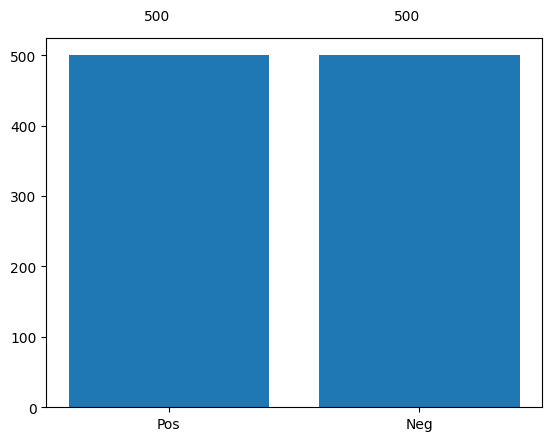

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(['Pos', 'Neg'], [len(data[data.Pos == 1]), len(data[data.Neg == 1])])
#buat angka diatas bar
for i, v in enumerate([len(data[data.Pos == 1]), len(data[data.Neg == 1])]):
    plt.text(i-.1, v+50, str(v))
plt.show()


### Clean data

In [ ]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [ ]:
data

,Text,Label,Pos,Neg,Text_Clean
0,So there is no way for me to plug it in here i...,0,0,1,So there is no way for me to plug it in here i...
1,"Good case, Excellent value.",1,1,0,Good case Excellent value
2,Great for the jawbone.,1,1,0,Great for the jawbone
3,Tied to charger for conversations lasting more...,0,0,1,Tied to charger for conversations lasting more...
4,The mic is great.,1,1,0,The mic is great
...,...,...,...,...,...
995,The screen does get smudged easily because it ...,0,0,1,The screen does get smudged easily because it ...
996,What a piece of junk.. I lose more calls on th...,0,0,1,What a piece of junk I lose more calls on this...
997,Item Does Not Match Picture.,0,0,1,Item Does Not Match Picture
998,The only thing that disappoint me is the infra...,0,0,1,The only thing that disappoint me is the infra...


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data['Text_Clean']]

In [ ]:
def lower_token(tokens):
    return [w.lower() for w in tokens]

lower_tokens = [lower_token(token) for token in tokens]

In [ ]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [ ]:
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]

In [ ]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]

In [ ]:
result = [' '.join(sen) for sen in filtered_words]

In [ ]:
data['Text_Final'] = result

In [ ]:
data['tokens'] = filtered_words

In [ ]:
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]

In [ ]:
data[:4]

,Text_Final,tokens,Label,Pos,Neg
0,way plug us unless go converter,"[way, plug, us, unless, go, converter]",0,0,1
1,good case excellent value,"[good, case, excellent, value]",1,1,0
2,great jawbone,"[great, jawbone]",1,1,0
3,tied charger conversations lasting 45 minutesm...,"[tied, charger, conversations, lasting, 45, mi...",0,0,1


### Split data into test and train

In [ ]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [ ]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

4818 words total, with a vocabulary size of 1686
Max sentence length is 17


In [ ]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

542 words total, with a vocabulary size of 366
Max sentence length is 14


### Load Google News Word2Vec model

In [ ]:
word2vec_path = '/content/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

### Get Embeddings

In [ ]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [ ]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

### Tokenize and Pad sequences

In [ ]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 1686 unique tokens.


In [ ]:
from keras.utils import pad_sequences

In [ ]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(1687, 300)


In [ ]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

### Define CNN

In [ ]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):

    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [ ]:
label_names = ['Pos', 'Neg']

In [ ]:
y_train = data_train[label_names].values

In [ ]:
x_train = train_cnn_data
y_tr = y_train

In [ ]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM,
                len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      506100      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 49, 200)      120200      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 200)      180200      ['embedding[0][0]']              
                                                                                              

### Train CNN

In [ ]:
num_epochs = 10
batch_size = 34

In [ ]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/10
24/24 [==============================] - 7s 110ms/step - loss: 0.6038 - acc: 0.7086 - val_loss: 0.5614 - val_acc: 0.7333
Epoch 2/10
24/24 [==============================] - 2s 96ms/step - loss: 0.3422 - acc: 0.8667 - val_loss: 0.3604 - val_acc: 0.8667
Epoch 3/10
24/24 [==============================] - 2s 92ms/step - loss: 0.1757 - acc: 0.9469 - val_loss: 0.3590 - val_acc: 0.8333
Epoch 4/10
24/24 [==============================] - 2s 92ms/step - loss: 0.0871 - acc: 0.9778 - val_loss: 0.3441 - val_acc: 0.8333
Epoch 5/10
24/24 [==============================] - 2s 92ms/step - loss: 0.0539 - acc: 0.9815 - val_loss: 0.4338 - val_acc: 0.8444
Epoch 6/10
24/24 [==============================] - 2s 94ms/step - loss: 0.0295 - acc: 0.9938 - val_loss: 0.6195 - val_acc: 0.8222
Epoch 7/10
24/24 [==============================] - 2s 92ms/step - loss: 0.0210 - acc: 0.9938 - val_loss: 0.4580 - val_acc: 0.8333
Epoch 8/10
24/24 [==============================] - 2s 94ms/step - loss: 0.0167 - 

### Test CNN

In [ ]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 299ms/step


In [ ]:
labels = [1, 0]

In [ ]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
data_test.Label.value_counts()

1    50
0    50
Name: Label, dtype: int64

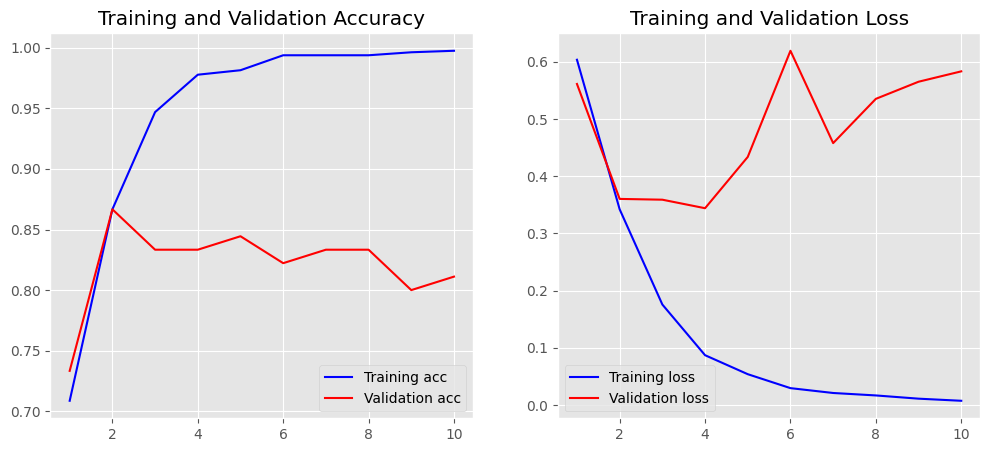

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss=history.history['val_loss']
    x = range(1, len(acc)+1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

plot_history(hist)

In [ ]:
#print hasil akurasi dari data test
print("Akurasi : ", sum(data_test.Label==prediction_labels)/len(prediction_labels))

Akurasi :  0.82


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(data_test.Label, prediction_labels))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



[[40 10]
 [ 8 42]]


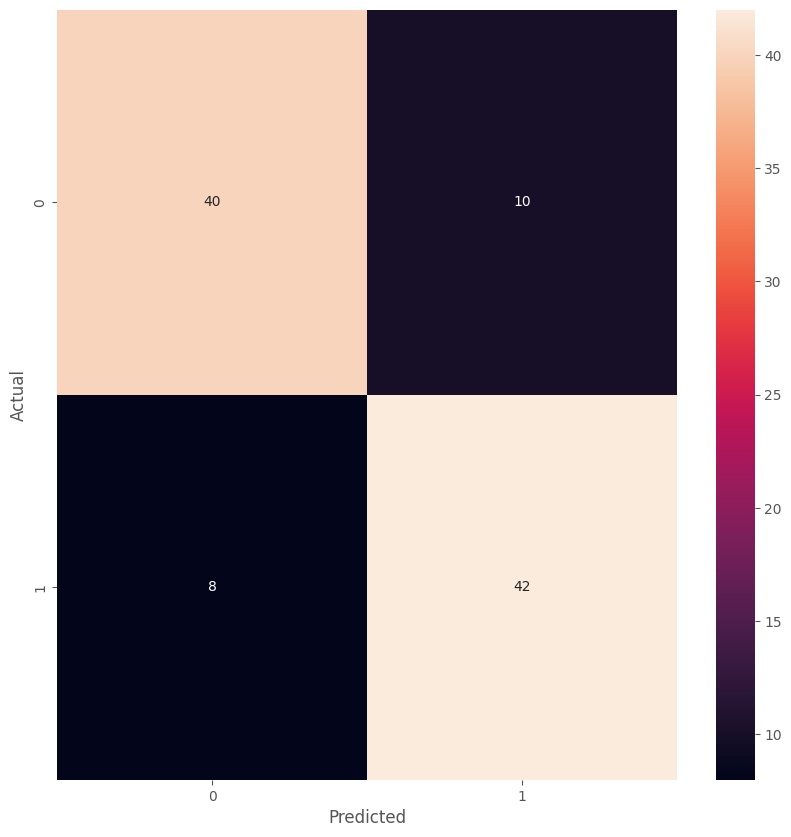

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

cm = confusion_matrix(data_test.Label, prediction_labels)
print(cm)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
prediction_labels

[1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1]

In [ ]:
data_test

,Text_Final,tokens,Label,Pos,Neg
521,thanks amazon things need good price,"[thanks, amazon, things, need, good, price]",1,1,0
737,tracfonewebsite user friendly makes easy toact...,"[tracfonewebsite, user, friendly, makes, easy,...",1,1,0
740,would highly recommend product,"[would, highly, recommend, product]",1,1,0
660,fit palm tungsten e2 broke first time tried plug,"[fit, palm, tungsten, e2, broke, first, time, ...",0,0,1
411,highly recommend device everyone,"[highly, recommend, device, everyone]",1,1,0
...,...,...,...,...,...
436,wish could return unit get back money,"[wish, could, return, unit, get, back, money]",0,0,1
764,wont work right atleast,"[wont, work, right, atleast]",0,0,1
88,product excellent works better verizon one boy...,"[product, excellent, works, better, verizon, o...",1,1,0
63,buy different phone,"[buy, different, phone]",0,0,1


In [ ]:
data_hasil=data_test.copy()
data_hasil['prediksi']=prediction_labels
data_hasil=data_hasil[['Text_Final', 'tokens', 'Label', 'prediksi']]

In [ ]:
data_hasil

,Text_Final,tokens,Label,prediksi
521,thanks amazon things need good price,"[thanks, amazon, things, need, good, price]",1,1
737,tracfonewebsite user friendly makes easy toact...,"[tracfonewebsite, user, friendly, makes, easy,...",1,1
740,would highly recommend product,"[would, highly, recommend, product]",1,1
660,fit palm tungsten e2 broke first time tried plug,"[fit, palm, tungsten, e2, broke, first, time, ...",0,0
411,highly recommend device everyone,"[highly, recommend, device, everyone]",1,1
...,...,...,...,...
436,wish could return unit get back money,"[wish, could, return, unit, get, back, money]",0,0
764,wont work right atleast,"[wont, work, right, atleast]",0,1
88,product excellent works better verizon one boy...,"[product, excellent, works, better, verizon, o...",1,1
63,buy different phone,"[buy, different, phone]",0,0
